In [1]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de seaborn
sns.set(style="whitegrid")

In [2]:
df_tr = pd.read_csv(r"..\data\raw\prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv")
df_hist_scores = pd.read_csv(r"..\data\raw\prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv")
df_clientes = pd.read_csv(r"..\data\raw\prueba_op_master_customer_data_enmascarado_completa.csv")
df_pagos = pd.read_csv(r"..\data\raw\prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv")

In [3]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568251 entries, 0 to 568250
Data columns (total 49 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   nit_enmascarado                  568251 non-null  int64  
 1   num_oblig_orig_enmascarado       568251 non-null  int64  
 2   num_oblig_enmascarado            568251 non-null  int64  
 3   fecha_var_rpta_alt               568251 non-null  int64  
 4   var_rpta_alt                     568251 non-null  int64  
 5   tipo_var_rpta_alt                568251 non-null  object 
 6   banca                            568251 non-null  object 
 7   segmento                         568251 non-null  object 
 8   producto                         568251 non-null  object 
 9   producto_cons                    568251 non-null  object 
 10  aplicativo                       568251 non-null  object 
 11  min_mora                         568251 non-null  int64  
 12  ma

In [4]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430000 entries, 0 to 429999
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   nit_enmascarado        430000 non-null  int64  
 1   cod_tipo_doc           430000 non-null  int64  
 2   tipo_cli               430000 non-null  object 
 3   ctrl_terc              430000 non-null  object 
 4   genero_cli             422038 non-null  object 
 5   ano_nac_cli            422058 non-null  float64
 6   edad_cli               422058 non-null  float64
 7   estado_civil           393526 non-null  object 
 8   tipo_vivienda          135123 non-null  object 
 9   num_hijos              422058 non-null  float64
 10  personas_dependientes  422055 non-null  float64
 11  nivel_academico        184998 non-null  object 
 12  ocup                   406747 non-null  object 
 13  act_econom             398632 non-null  object 
 14  sector                 396732 non-nu

In [5]:
df_hist_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804836 entries, 0 to 4804835
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   nit_enmascarado        int64  
 1   num_oblig_enmascarado  int64  
 2   fecha_corte            int64  
 3   lote                   int64  
 4   prob_propension        float64
 5   prob_alrt_temprana     float64
 6   prob_auto_cura         float64
dtypes: float64(3), int64(4)
memory usage: 256.6 MB


In [6]:
df_pagos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4855035 entries, 0 to 4855034
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   nit_enmascarado        int64  
 1   num_oblig_enmascarado  int64  
 2   fecha_corte            int64  
 3   producto               object 
 4   aplicativo             object 
 5   segmento               object 
 6   valor_cuota_mes        float64
 7   pago_total             float64
 8   fecha_pago_minima      float64
 9   fecha_pago_maxima      float64
 10  porc_pago              float64
 11  marca_pago             object 
 12  ajustes_banco          object 
dtypes: float64(5), int64(3), object(5)
memory usage: 481.5+ MB


## Limpieza dfs

Asegurarnos de que en cada mes solo se tenga una fecha de ingestion

In [7]:
# Group by 'year' and 'month' to find the maximum 'ingestion_day'
df_demo_clean = df_clientes.groupby(['year', 'month'])['ingestion_day'].max().reset_index()

# Rename 'ingestion_day' to 'max_ingestion_day'
df_demo_clean = df_demo_clean.rename(columns={'ingestion_day': 'max_ingestion_day'})

# Merge with the original DataFrame on 'year', 'month', and 'max_ingestion_day'
df_demo_clean = df_demo_clean.merge(
    df_clientes,
    left_on=['year', 'month', 'max_ingestion_day'],
    right_on=['year', 'month', 'ingestion_day'],
    how='inner'
)

# Drop the 'max_ingestion_day' column after the merge
df_demo_clean = df_demo_clean.drop(columns=['max_ingestion_day'])

# Display the final DataFrame
df_demo_clean.groupby(['year', 'month'])['ingestion_day'].unique()  


year  month
2023  7        [31]
      8        [31]
      9        [30]
      10       [31]
      11       [30]
      12       [31]
Name: ingestion_day, dtype: object

creacion de id unico para cada cliente. de acuerdo a la descripcion del reto se realizara una combiancion Donde, la columna ID se compone de las columnas nit_enmascarado, num_oblig_orig_enmascarado, num_oblig_enmascarado concatenado por el carácter "#"

In [8]:
# Crear ID de unión
df_tr["id"] = df_tr["nit_enmascarado"].astype(str) + "#" + \
              df_tr["num_oblig_orig_enmascarado"].astype(str) + "#" + \
              df_tr["num_oblig_enmascarado"].astype(str)


In [9]:
# Copias limpias para merge
df_tr["fecha_corte"] = df_tr["fecha_var_rpta_alt"]
df_pagos['fecha_corte'] = df_pagos['fecha_corte'].astype(str).apply(lambda x: x[:-2]).astype(int)

# Unificación de llaves para merge
keys = ["nit_enmascarado", "num_oblig_enmascarado", "fecha_corte"]

# Merge con scores históricos
df_master = df_tr.merge(df_hist_scores, on=keys, how="left", suffixes=("", "_score"))

# Merge con pagos históricos
df_master = df_master.merge(df_pagos, on=keys, how="left", suffixes=("", "_pago"))

# ultima ingestion
df_master = df_master[df_master["fecha_var_rpta_alt"]==df_master.fecha_var_rpta_alt.max()]
# Validación
print("Shape después de unir scores y pagos:", df_master.shape)
print("Duplicados en identificador:", df_master.duplicated(subset=["id"]).sum())
print("Duplicados en todas las columnas:", df_master.duplicated().sum())

Shape después de unir scores y pagos: (100466, 65)
Duplicados en identificador: 0
Duplicados en todas las columnas: 0


In [10]:
cat_vars = [
    'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons', 'aplicativo',
    'rango_mora', 'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3',
    'alter_posible1_2', 'alter_posible2_2', 'alter_posible3_2',
    'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult',
    'marca_alt_rank', 'marca_alt_apli', 'pagos_tanque', 'marca_debito_mora',
    'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago',
    'marca_alternativa', 'marca_alternativa_orig',
    'producto_pago', 'aplicativo_pago', 'segmento_pago', 'marca_pago_pago', 'ajustes_banco'
]

num_vars = [
    'nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado',
    'fecha_var_rpta_alt', 'var_rpta_alt', 'min_mora', 'max_mora', 'dias_mora_fin',
    'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento',
    'cant_alter_posibles', 'cant_gestiones', 'cant_gestiones_binario', 'rpc',
    'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo',
    'cant_acuerdo_binario', 'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota',
    'pago_mes', 'porc_pago_mes', 'fecha_corte', 'lote',
    'prob_propension', 'prob_alrt_temprana', 'prob_auto_cura',
    'valor_cuota_mes_pago', 'pago_total', 'fecha_pago_minima', 'fecha_pago_maxima',
    'porc_pago'
]

total_variables = num_vars + cat_vars
print("Número de variables numéricas:", len(num_vars))
print("Número de variables categóricas:", len(cat_vars))
print("Número total de variables:", len(total_variables))
print("Número de variables en el DataFrame:", len(df_master.columns))
print(f"La variable faltante es: {set(df_master.columns) - set(num_vars + cat_vars)} la cual es la variable identificadora")

Número de variables numéricas: 35
Número de variables categóricas: 29
Número total de variables: 64
Número de variables en el DataFrame: 65
La variable faltante es: {'id'} la cual es la variable identificadora


## limpieza categoricas

In [11]:
for col in cat_vars:
    df_master[col] = df_master[col].astype("category")
    print(f"Distribucion de cateforias en {col}:")
    print(df_master[col].value_counts())
    print("\n")

Distribucion de cateforias en tipo_var_rpta_alt:
tipo_var_rpta_alt
e_cero_tipo_2    50267
a_uno_tipo_1     29893
b_uno_tipo_2     14308
d_cero_tipo_1     3158
c_uno_tipo_3      2840
Name: count, dtype: int64


Distribucion de cateforias en banca:
banca
Banca Personas    86425
Independientes    10479
Banca Pyme         3562
Name: count, dtype: int64


Distribucion de cateforias en segmento:
segmento
Personal         63571
Personal plus    19287
Micropyme        10479
Pymes             3562
Social            3014
Preferencial       553
Name: count, dtype: int64


Distribucion de cateforias en producto:
producto
TARJETA DE CREDITO       43380
LIBRE INVERSION          35450
ROTATIVOS                13867
CARTERA ORDINARIA         2205
LIBRANZA                  1918
HIPOTECARIO VIVIENDA      1859
CARTERA MICROCREDITO      1079
CREDIPAGO                  254
SOBREGIRO                  144
LEASING HABITACIONAL       109
CREDITOS DE CONSUMO         43
TARJETAS DE CREDITO         34
Titularizad

In [12]:
reemplazos_basura = ["", " ", "nan", "NaN", "NA", "NAN", "null", "NULL", "?", "N.A"]

for col in cat_vars:
    if col in df_master.columns:
        df_master[col] = df_master[col].replace(reemplazos_basura, np.nan)

# Agregar "SIN_INFO" como categoría válida antes de usar fillna
for col in cat_vars:
    if col in df_master.columns and df_master[col].isna().sum() > 0:
        if pd.api.types.is_categorical_dtype(df_master[col]):
            # Agregar "SIN_INFO" como categoría
            df_master[col] = df_master[col].cat.add_categories("SIN_INFO")
        # Rellenar los valores nulos con "SIN_INFO"
        df_master[col] = df_master[col].fillna("SIN_INFO")

# Convertir a categoría
for col in cat_vars:
    if col in df_master.columns:
        df_master[col] = df_master[col].astype("category")

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_10120\3445485624.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_master[col] = df_master[col].replace(reemplazos_basura, np.nan)
C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_10120\3445485624.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_master[col]):


disminucion de la cardinalidad

In [13]:
def reducir_cardinalidad(df, col, top_n=30):
    top_categorias = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_categorias else "OTROS")
    return df

# Aplicar a todas las categóricas
for col in cat_vars:
    if col in df_master.columns:
        df_master = reducir_cardinalidad(df_master, col, top_n=20)

for col in cat_vars:
    if col in df_master.columns:
        df_master[col] = df_master[col].astype("category")


## Variables numericas

In [14]:
df_master[num_vars].describe()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_obligacion,vlr_vencido,...,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,valor_cuota_mes_pago,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago
count,100466.000000,1.004660e+05,1.004660e+05,100466.0,100466.000000,100466.000000,100466.000000,100466.000000,1.003270e+05,1.004660e+05,...,100466.0,99240.000000,99240.000000,99240.000000,99240.000000,1.003280e+05,1.003280e+05,5.081200e+04,5.081200e+04,98652.000000
mean,309029.964894,5.349694e+05,5.443337e+05,202312.0,0.468228,29.855752,52.440119,41.125057,1.208417e+07,1.106631e+06,...,202312.0,1.654152,0.531238,0.615105,0.271410,1.059549e+06,9.926373e+05,2.023116e+07,2.023119e+07,116.488789
std,182269.037923,3.118591e+05,3.105488e+05,0.0,0.498992,27.007699,32.940127,36.870957,2.536977e+07,2.656251e+06,...,0.0,0.729291,0.230176,0.118700,0.141774,2.620798e+06,7.585863e+06,2.220015e+02,2.377158e+02,637.737875
min,2.000000,4.030000e+02,7.000000e+00,202312.0,0.000000,1.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,...,202312.0,1.000000,0.044572,0.043320,0.047282,0.000000e+00,0.000000e+00,2.023110e+07,2.023110e+07,0.000000
25%,155053.250000,2.665710e+05,2.785465e+05,202312.0,0.000000,3.000000,27.000000,0.000000,1.618772e+06,2.068070e+05,...,202312.0,1.000000,0.336714,0.556302,0.171476,1.928368e+05,0.000000e+00,2.023112e+07,2.023113e+07,0.000000
50%,301665.000000,5.320875e+05,5.482545e+05,202312.0,0.000000,24.000000,48.000000,34.000000,4.337130e+06,4.885465e+05,...,202312.0,2.000000,0.563984,0.618711,0.231551,4.803750e+05,0.000000e+00,2.023113e+07,2.023121e+07,0.000000
75%,465036.750000,8.017955e+05,8.124738e+05,202312.0,1.000000,50.000000,76.000000,69.000000,1.122777e+07,1.119570e+06,...,202312.0,2.000000,0.735701,0.702482,0.324451,1.099261e+06,7.120125e+04,2.023120e+07,2.023122e+07,22.000000
max,634689.000000,1.080335e+06,1.080719e+06,202312.0,1.000000,90.000000,1459.000000,609.000000,9.254330e+08,3.672875e+08,...,202312.0,3.000000,0.957057,0.929135,0.942418,3.672875e+08,8.552992e+08,2.024010e+07,2.024010e+07,75729.000000


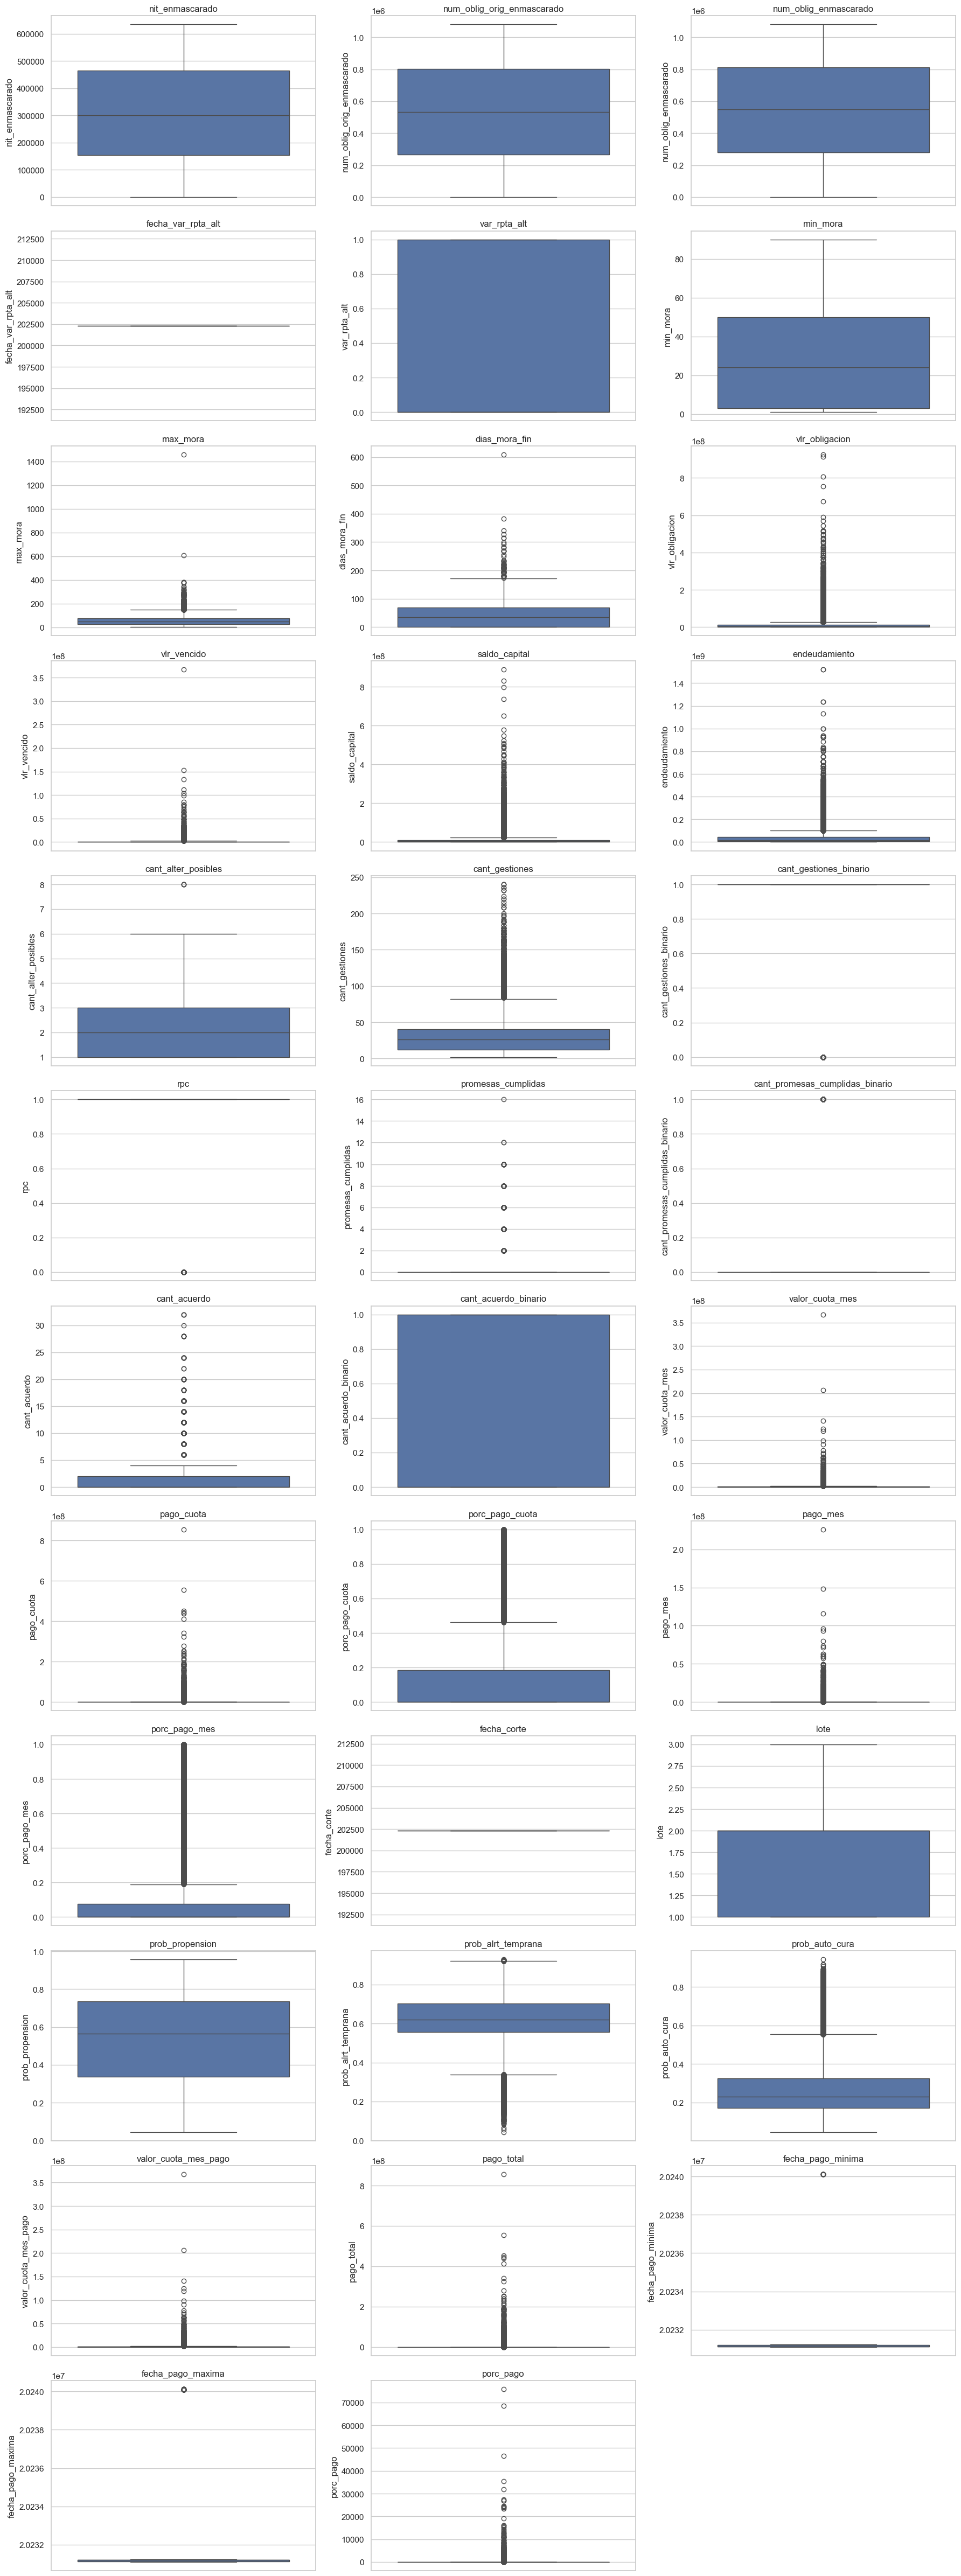

In [15]:
# Número de columnas por fila
cols_per_row = 3
num_plots = len(num_vars)
num_rows = (num_plots + cols_per_row - 1) // cols_per_row

# Tamaño de figura ajustado
fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(6 * cols_per_row, 4 * num_rows))
axes = axes.flatten()

# Graficar cada variable numérica
for i, col in enumerate(num_vars):
    if col in df_master.columns:
        sns.boxplot(data=df_master, y=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel("")
        
# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
def tratamiento_numericas_basico(df, num_vars, log_vars=None, winsor_vars=None, verbose=True):
    """
    - Imputa nulos con la mediana
    - Aplica log1p a variables seleccionadas
    - Winsoriza variables al percentil 1 y 99
    """
    df = df.copy()

    # Imputación de nulos con mediana
    for col in num_vars:
        if df[col].isnull().sum() > 0:
            mediana = df[col].median()
            df[col] = df[col].fillna(mediana)
            if verbose:
                print(f"[Imputación] '{col}': nulos imputados con mediana = {mediana}")

    # Log-transformación (opcional)
    if log_vars:
        for col in log_vars:
            if col in df.columns:
                df[f"{col}_log"] = np.log1p(df[col])
                if verbose:
                    print(f"[Log1p] '{col}': transformación log aplicada")

    # Winsorización al 1% y 99%
    if winsor_vars:
        for col in winsor_vars:
            if col in df.columns:
                p01 = df[col].quantile(0.01)
                p99 = df[col].quantile(0.99)
                df[col] = df[col].clip(lower=p01, upper=p99)
                if verbose:
                    print(f"[Winsor] '{col}': valores fuera de P01={p01:.2f} y P99={p99:.2f} fueron recortados")

    return df

In [17]:
# Variables con outliers a tratar
winsor_vars = ["vlr_obligacion", "saldo_capital", "pago_total", "cant_gestiones", "rpc"]

# Variables a transformar con log
log_vars = ["vlr_obligacion", "saldo_capital", "pago_total"]

# Aplicar función
df_master_clean = tratamiento_numericas_basico(
    df=df_master,
    num_vars=num_vars,
    log_vars=log_vars,
    winsor_vars=winsor_vars,
    verbose=True
)


[Imputación] 'vlr_obligacion': nulos imputados con mediana = 4337130.0
[Imputación] 'cant_gestiones': nulos imputados con mediana = 26.0
[Imputación] 'cant_acuerdo': nulos imputados con mediana = 0.0
[Imputación] 'valor_cuota_mes': nulos imputados con mediana = 479231.88
[Imputación] 'pago_cuota': nulos imputados con mediana = 0.0
[Imputación] 'porc_pago_mes': nulos imputados con mediana = 0.0
[Imputación] 'lote': nulos imputados con mediana = 2.0
[Imputación] 'prob_propension': nulos imputados con mediana = 0.5639840857267475
[Imputación] 'prob_alrt_temprana': nulos imputados con mediana = 0.6187114489036787
[Imputación] 'prob_auto_cura': nulos imputados con mediana = 0.2315514225295823
[Imputación] 'valor_cuota_mes_pago': nulos imputados con mediana = 480375.0
[Imputación] 'pago_total': nulos imputados con mediana = 0.0
[Imputación] 'fecha_pago_minima': nulos imputados con mediana = 20231128.0
[Imputación] 'fecha_pago_maxima': nulos imputados con mediana = 20231206.0
[Imputación] 'po

In [18]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100466 entries, 1 to 568252
Data columns (total 68 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   nit_enmascarado                  100466 non-null  int64   
 1   num_oblig_orig_enmascarado       100466 non-null  int64   
 2   num_oblig_enmascarado            100466 non-null  int64   
 3   fecha_var_rpta_alt               100466 non-null  int64   
 4   var_rpta_alt                     100466 non-null  int64   
 5   tipo_var_rpta_alt                100466 non-null  category
 6   banca                            100466 non-null  category
 7   segmento                         100466 non-null  category
 8   producto                         100466 non-null  category
 9   producto_cons                    100466 non-null  category
 10  aplicativo                       100466 non-null  category
 11  min_mora                         100466 non-null  int64  

In [19]:
# fataframe de porcentaje de nulos por variable
df_nulls = pd.DataFrame(df_master_clean.isnull().mean() * 100).reset_index()
df_nulls.columns = ["variable", "porcentaje_nulos"]
df_nulls = df_nulls.sort_values(by="porcentaje_nulos", ascending=False)
df_nulls = df_nulls[df_nulls["porcentaje_nulos"] > 0]
df_nulls.reset_index(drop=True, inplace=True)
df_nulls

,variable,porcentaje_nulos


In [20]:
df_master_clean.duplicated().sum()

0

In [21]:
# exportar a csv
df_master_clean.to_csv(r"..\data\procesed\df_master_clean.csv", index=False)